In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import time
import torch
import os
from PIL import Image

import os
import time
import torchvision
from torch import nn
from torchsummary import summary
from torch.utils.data import Subset, WeightedRandomSampler, Dataset, DataLoader
import pandas as pd
from torchvision import transforms

from os.path import exists

c:\Users\cseak\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\cseak\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


#### Preprocessing

In [2]:
## transform original label to csv format

# trains = []
# tests = []
# with open('dataset/label.txt', 'r') as label_f:
#   line = label_f.readline()
#   while line:
#     splitted = line.split(' ')
#     names = splitted[0].split('.')
#     if line.startswith('train_'):
#       trains.append([str(names[0] + '_aligned.' + names[1]), int(splitted[1][0]) - 1])
#     else:
#       tests.append([str(names[0] + '_aligned.' + names[1]), int(splitted[1][0]) - 1])

#     line = label_f.readline()

# pd.DataFrame(data=trains, columns=['path', 'label']).to_csv('dataset/train.csv', index=False)
# pd.DataFrame(data=tests, columns=['path', 'label']).to_csv('dataset/test.csv', index=False)

In [3]:
CLASS_LABELS = {
    '0': 'Surprise',
    '1': 'Fear',
    '2': 'Disgust',
    '3': 'Happiness',
    '4': 'Sadness',
    '5': 'Anger',
    '6': 'Neutral',
}

#Check dataset distribution
pd.read_csv('dataset/train.csv')['label'].value_counts(), pd.read_csv('dataset/test.csv')['label'].value_counts()

(3    4772
 6    2524
 4    1982
 0    1290
 2     717
 5     705
 1     281
 Name: label, dtype: int64,
 3    1185
 6     680
 4     478
 0     329
 5     162
 2     160
 1      74
 Name: label, dtype: int64)

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def load_image(path):
    img = Image.open(path)
    # img = Image.open(path)
    img.load()
    
    return transforms.ToTensor()(img)

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#### Dataset and Dataloader

In [5]:
IMG_PATH = 'dataset/img/'
# IMG_PATH = 'dataset/test/'
INPUT_SIZE=100*100

class CustomImageNetDataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.img_path = IMG_PATH
        self.df = pd.read_csv('dataset/train.csv' if train else 'dataset/test.csv')
        # self.df = pd.read_csv('dataset/train.csv' if train else 'dataset/test.csv').sample(n=1000)

        self.transform = transform

    def __len__(self):
        return len(self.df.index)

    def get_targets(self):
        return self.df['label']

    def __getitem__(self, idx):
        obj = self.df.iloc[idx]
        image = load_image(self.img_path + obj['path'])
        label = obj['label']

        # if image.shape[0] == 1:
        #   image = read_image(self.img_path + obj['name'], ImageReadMode.GRAY)

        if self.transform:
          image = self.transform(image.type(torch.FloatTensor))

        return image, label

class CustomDataModule:
    def __init__(self, train_transforms = None, test_transforms = None, bs=32):
        super().__init__()
        self.bs = bs
        
        self.transform = train_transforms
        
        self.test_transform = test_transforms

    def prepare_data(self):
        pass

    def __balance_val_split(self, dataset, val_split=0.):
        targets = np.array(dataset.get_targets())
        train_indices, val_indices = train_test_split(
            np.arange(targets.shape[0]),
            test_size=val_split,
            stratify=targets
        )
        
        train_dataset = Subset(dataset, indices=train_indices)
        val_dataset = Subset(dataset, indices=val_indices)

        return train_dataset, val_dataset
    
    def __oversampling(self, dataset):
        targets = [label for img, label in iter(dataset)]
            
        max_cnt_in_dataset = 0
        class_weights = []
        for i in range(len(CLASS_LABELS)):
            cnt_in_dataset = (np.array(targets) == i).sum()
            class_weights.append(1 / cnt_in_dataset * 1000)
            
            if max_cnt_in_dataset < cnt_in_dataset:
                max_cnt_in_dataset = cnt_in_dataset
        
        sample_weights = [0] * len(dataset)
        for ind, (data, label) in enumerate(dataset):
            sample_weights[ind] = class_weights[label]
        
        sampler = WeightedRandomSampler(sample_weights, num_samples=30000, replacement=True)
        
        return sampler
        
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_ds_all = CustomImageNetDataset(transform=self.transform, train=True)
            self.train_ds, self.val_ds = self.__balance_val_split(train_ds_all, val_split=0.05)

        if stage == "test" or stage == "predict" or stage is None:
            self.test_ds = CustomImageNetDataset(transform=self.test_transform, train=False)

        return self

    def train_dataloader(self):
        # sampler = self.__oversampling(self.train_ds)
        
        # return DataLoader(self.train_ds, batch_size=self.bs)
        return DataLoader(self.train_ds, batch_size=self.bs)

    def val_dataloader(self):
        # sampler = self.__oversampling(self.val_ds)
        
        return DataLoader(self.val_ds, batch_size=self.bs)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs)

    def predict_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs)

In [6]:
from collections import Counter

dl = CustomDataModule().setup("fit").train_dataloader()
all_labels = []
for imgs, labels in dl:
    all_labels.extend(labels.detach_().cpu().tolist())

    
# Check data distribution after applied oversampling based on weight
print("Dataset count:", len(all_labels))
Counter(all_labels)

Dataset count: 11657


Counter({6: 2398, 3: 4533, 0: 1225, 4: 1883, 5: 670, 2: 681, 1: 267})

#### CNN Model Initialization

In [7]:
class FacialClassification(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
        )

        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=128, out_features=len(CLASS_LABELS))
        )
    
    def forward(self, x):
        # print(x.shape)
        x = self.conv_layer(x)

        x = self.fc(x)

        return x

summary(FacialClassification(3).to("cuda"), (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]           4,736
              ReLU-2           [-1, 32, 94, 94]               0
            Conv2d-3           [-1, 64, 90, 90]          51,264
              ReLU-4           [-1, 64, 90, 90]               0
         MaxPool2d-5           [-1, 64, 30, 30]               0
            Conv2d-6          [-1, 128, 26, 26]         204,928
              ReLU-7          [-1, 128, 26, 26]               0
         AvgPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 6, 6]         147,584
             ReLU-10            [-1, 128, 6, 6]               0
        AvgPool2d-11            [-1, 128, 2, 2]               0
          Flatten-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
             ReLU-14                  [

In [8]:
class FacialClassificationTL(nn.Module):
    def __init__(self, in_channels=3, requires_grad=False, pretrained=True):
        super().__init__()

        self.model_ft = torchvision.models.resnet18(pretrained=pretrained)

        for param in self.model_ft.parameters():
            param.requires_grad_(requires_grad)
        
        self.model_ft.conv1.in_channels = in_channels
        num_ftrs = self.model_ft.fc.in_features
        
        self.model_ft.fc = nn.Linear(num_ftrs, len(CLASS_LABELS))

    def forward(self, x):
      out = self.model_ft(x)

      return out
  
# FacialClassificationTL()
summary(FacialClassificationTL(3).to("cuda"), (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

Display sample image

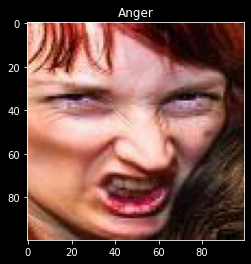

In [9]:
img, label = next(iter(CustomDataModule().setup("fit").train_dataloader().dataset))
# one_img = btx[0][0]
# one_label = btx[1][0]
# one_img.shape
# imshow(img)

plt.title(CLASS_LABELS[str(label)])
img =img.numpy()
if img.shape[0] == 3:
  img = img.transpose((1, 2, 0))
plt.imshow(img.squeeze(), cmap='gray' if img.shape[0] == 1 else None)

#### Train, Evaluate functions

In [10]:
class_weights = []
labels = pd.read_csv('dataset/train.csv')['label'].value_counts(normalize=True)

for label, weight in zip(labels.keys(), labels):
    class_weights.insert(label, weight)
    
labels, class_weights

(3    0.388884
 6    0.205688
 4    0.161519
 0    0.105126
 2    0.058430
 5    0.057453
 1    0.022900
 Name: label, dtype: float64,
 [0.10512590660907832,
  0.022899519191589928,
  0.38888436150273004,
  0.0584304457664412,
  0.20568820797001058,
  0.16151902860402576,
  0.057452530356124194])

In [11]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(np.array(class_weights)).to(DEVICE).float())

def _train(model, optimizer, train_dl):
    losses = []
    rtn_preds = []
    rtn_labels = []
    model.train()
    for images, labels in train_dl:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # print(images.shape, labels.shape)
        # Forward pass
        outputs = model(images)
        # print(outputs.shape)
        loss = criterion(outputs, labels)
        
        predicted = torch.argmax(outputs, dim=1).long()
        
        rtn_preds.extend(predicted.detach().cpu().numpy())
        rtn_labels.extend(labels.detach().cpu().numpy())
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses, rtn_labels, rtn_preds

def train(model, learning_rate, train_dl, val_dl, epochs, log_path: str):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(epochs):
        losses, rtn_labels, rtn_preds = _train(model, optimizer, train_dl)
            
        train_acc = (np.array(rtn_preds) == np.array(rtn_labels)).sum() / len(rtn_labels)
        
        val_loss, val_acc, val_labels, val_preds = evaluate(model, val_dl, testing=False)
        rtn_preds.extend(np.array(val_preds))
        rtn_labels.extend(np.array(val_labels))
        
        scheduler.step()
            
        print ('Epoch [{}/{}], Training Loss: {:.4f}, Train Accuracy: {:.4f}' 
                      .format(epoch+1, epochs, sum(losses) / len(losses), train_acc))
        print ('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
                      .format(epoch+1, epochs, val_loss, val_acc))
        
        if not exists(log_path):
            os.mkdir(log_path)
            
        with open(log_path + "train.log", "a") as f:
            if os.path.getsize(log_path + "train.log") <= 0:
                f.write("epoch\ttrain_acc\ttrain_loss\tval_acc\tval_loss\tlabels\tpredictions\n")
                
            f.write(f"{epoch}\t{train_acc}\t{sum(losses) / len(losses)}\t{val_acc}\t{val_loss}\t{','.join([str(num) for num in rtn_labels])}\t{','.join([str(num) for num in rtn_preds])}\n")
    
    # Start feeding validation set to the network
    print()
    print("Start training on validation set:")
    for epoch in range(epochs):
        loss, acc, rtn_labels, rtn_preds = validate(model, optimizer, val_dl)
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Train on Validation Set Accuracy: {:.4f}' 
                      .format(epoch+1, epochs, loss, acc))
    

def validate(model, optimizer, val_dl, testing=True):
    losses, rtn_labels, rtn_preds = _train(model, optimizer, val_dl)

    return np.array(losses).mean(), (np.array(rtn_preds) == np.array(rtn_labels)).sum() / len(rtn_labels), rtn_labels, rtn_preds 

def train_find_best_lr(model, learning_rate, train_dl, val_dl, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    e_losses = []
    model.train()
    for epoch in range(epochs):
        losses, _, _ = _train(model, optimizer, train_dl)
            
        val_loss, val_acc, val_labels, val_preds = evaluate(model, val_dl, testing=False)
        
        scheduler.step()
        
        e_losses.append(np.array(losses).mean())
    
    return np.array(e_losses).mean()


def evaluate(model, val_dl, log_path = '', testing=True):
    # if testing:
    #     plt.figure(figsize=(50, 30))
    
    with torch.no_grad():
        if testing:
            model.eval()
            
        correct = 0
        total = 0
        rtn_preds = []
        rtn_labels = []
        rtn_losses = []
        i = 0
        for images, labels in val_dl:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # print(outputs[0])
            probabs = nn.functional.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1).long()
            # print(predicted)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

            rtn_preds.extend(predicted.detach().cpu().numpy())
            rtn_labels.extend(labels.detach().cpu().numpy())
            rtn_losses.append(loss.detach().cpu().item())
            
            if not testing:
                continue
            
            if i > 16:
                continue
            
            if not exists(log_path + '/test-images'):
                os.mkdir(log_path + '/test-images')
            
            for ind, pred in enumerate(predicted):
                if i > 16:
                    break
            
                if predicted[ind] == labels[ind]:
                    continue
                
                plt.title("Probab: " + str(round(probabs[ind][pred].item() * 100) / 100) + " P: " + CLASS_LABELS[str(pred.item())] + ", A: " + CLASS_LABELS[str(labels[ind].cpu().item())])
                
                subtitle = ''
                top2 = probabs[ind].topk(2)
                for index in range(2):
                    subtitle += CLASS_LABELS[str(top2.indices[index].item())] +  " : " + str(round(top2.values[index].item() * 100) / 100) + ' '
                plt.suptitle(subtitle)
                
                plt.imshow(images[ind].mul_(0.5).add_(0.5).detach().cpu().numpy().transpose(1, 2, 0))
                plt.savefig(log_path + '/test-images/' + str(i) + '.png', bbox_inches='tight')
                # plt.show()
                i += 1
            
        
        if testing:
            if not exists(log_path):
                os.mkdir(log_path)
            
            with open(log_path + "test.log", "a") as f:
                if os.path.getsize(log_path + "test.log") <= 0:
                    f.write("test_acc\ttest_loss\tlabels\tpredictions\n")
                    
                f.write(f"{correct / total}\t{np.array(rtn_losses).mean()}\t{','.join([str(num) for num in rtn_labels])}\t{','.join([str(num) for num in rtn_preds])}\n")
            
            print('Accuracy of the network on the', total ,'validation images: {} %'.format(100 * correct / total))

    return np.array(rtn_losses).mean(), correct / total, rtn_labels, rtn_preds


#### Setup model, data augmentation and dataloader

In [12]:
# 15 339 total images in label.txt
LOG_PATH = 'logs/resnet18-ep30-weightedloss/'
EPOCHS = 30

facial_model = FacialClassificationTL(in_channels=3, requires_grad=True, pretrained=True).to(DEVICE)
# facial_model = FacialClassification(in_channels=3).to(DEVICE)

#resnet18 mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_module = CustomDataModule(
    train_transforms=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((100, 100)),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(degrees=(-90, 90)),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)]),
    test_transforms=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)]),
)

data_module.setup("fit")

#### Find optimal LR

In [13]:
# def find_best_lr():
#     lrs = [0.01, 0.005, 0.003, 0.001, 0.0005, 0.0003, 0.0001]
    
#     model = FacialClassificationTL(in_channels=3, requires_grad=True, pretrained=True).to(DEVICE)
    
#     losses = []
#     for exper_lr in lrs:
#         loss = train_find_best_lr(model, learning_rate=exper_lr, train_dl=data_module.train_dataloader(), val_dl=data_module.val_dataloader(), epochs=1)
        
#         losses.append(loss)
        
#         print('Done:', exper_lr)
        
#     return np.array(lrs), np.array(losses)
    
# lrs, losses = find_best_lr()

# plt.plot(lrs, losses)
# plt.ylabel('Loss')
# plt.xlabel('Learning Rate')
# plt.show()

The graph above shows that 0.001 is the optimal LR since when training we also reduce the LR with ExponentialLR.

#### Train the model

In [14]:
train(facial_model, learning_rate=0.001, epochs=EPOCHS, train_dl=data_module.train_dataloader(), val_dl=data_module.val_dataloader(), log_path=LOG_PATH)

# facial_model.load_state_dict(torch.load('./checkpoints/resnet18-ep30-weightedloss.pt'))

Epoch [1/30], Training Loss: 1.6619, Train Accuracy: 0.3182
Epoch [1/30], Validation Loss: 1.5786, Validation Accuracy: 0.3681
Epoch [2/30], Training Loss: 1.4105, Train Accuracy: 0.4321
Epoch [2/30], Validation Loss: 1.3326, Validation Accuracy: 0.4805
Epoch [3/30], Training Loss: 1.2751, Train Accuracy: 0.4931
Epoch [3/30], Validation Loss: 1.2881, Validation Accuracy: 0.4886
Epoch [4/30], Training Loss: 1.1844, Train Accuracy: 0.5282
Epoch [4/30], Validation Loss: 1.2023, Validation Accuracy: 0.5635
Epoch [5/30], Training Loss: 1.1150, Train Accuracy: 0.5635
Epoch [5/30], Validation Loss: 1.0463, Validation Accuracy: 0.5749
Epoch [6/30], Training Loss: 1.0556, Train Accuracy: 0.5821
Epoch [6/30], Validation Loss: 1.0527, Validation Accuracy: 0.5863
Epoch [7/30], Training Loss: 0.9985, Train Accuracy: 0.6114
Epoch [7/30], Validation Loss: 0.9885, Validation Accuracy: 0.5896
Epoch [8/30], Training Loss: 0.9515, Train Accuracy: 0.6308
Epoch [8/30], Validation Loss: 0.9557, Validation A

#### test the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Accuracy of the network on the 3068 validation images: 74.41329856584093 %


'1'

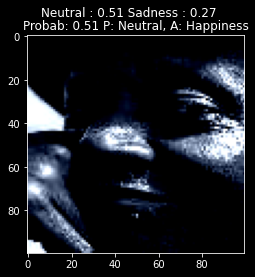

In [15]:
data_module.setup("test")

evaluate(facial_model, data_module.test_dataloader(), log_path=LOG_PATH, testing=True)
'1'

#### Make prediction

Time: 45.00389099121094 ms
Surprise : 0.0
Fear : 0.0
Disgust : 0.32
Happiness : 0.15
Sadness : 0.23
Anger : 0.3
Neutral : 0.01



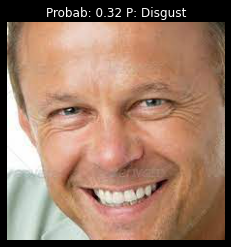

Surprise : 0.0
Fear : 0.0
Disgust : 0.27
Happiness : 0.04
Sadness : 0.42
Anger : 0.0
Neutral : 0.26



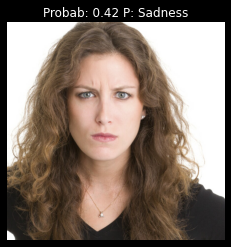

In [19]:
def predict(model, paths):
    row =len(paths)
    col = 1
    i = 1
#     plt.figure(figsize=(25, 20))
    
    with torch.no_grad():
        model.eval()
        start_time = time.time()
        images = torch.Tensor([transforms.Resize((100, 100))(load_image(x)).numpy() for x in paths]).to(DEVICE)
        
        outputs = model(images)
        end_time = time.time()
        
        print("Time:", (end_time-start_time) * 1000, "ms")
        
        probabs = nn.functional.softmax(outputs, dim=1)
        predicted = torch.argmax(probabs, dim=1).long()
        
        for ind, pred in enumerate(predicted):
            if images[ind].shape[0] == 1:
                plt.imshow(images[ind].detach().cpu().numpy().squeeze(), cmap='gray')
            else:
                plt.imshow(Image.open(paths[ind]))
                
            plt.axis('off')
            plt.title("Probab: " + str(round(probabs[ind][pred].item() * 100) / 100) + " P: " + CLASS_LABELS[str(pred.item())])
            for index, probab in enumerate(probabs[ind]):
                print(CLASS_LABELS[str(index)], ":", round(probab.item() * 100) / 100)
            print()
            plt.show()
            i += 1
            
predict(facial_model, ['./dataset/test/subject1.jpeg', './dataset/test/subject2.jpeg'])

In [17]:
if not exists('./checkpoints/resnet18-ep30-weightedloss.pt'):
    torch.save(facial_model.state_dict(), './checkpoints/resnet18-ep30-weightedloss.pt')